In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

import pymc as pm, vivarium_uw_covid as vuc, scipy

%load_ext autoreload
%autoreload 2

Thu Sep  3 11:33:24 PDT 2020


# Minimal version of COVID-19 Deconvolution Model

To use for discussion about TFP and RHMC.

In [2]:
%cd ~/projects/2020/covid_deconvolution/
import model
data = pd.read_csv('south_dakota_symp.csv', index_col='Date', parse_dates=True)
data

/ihme/homes/abie/projects/2020/covid_deconvolution


,n_pop,n_cc,n_sampled,n_symp
Date,,,,
2020-04-06,864821.521563,48.0,388.0,7.0
2020-04-07,864821.521563,32.0,926.0,8.0
2020-04-08,864821.521563,73.0,921.0,3.0
2020-04-09,864821.521563,54.0,784.0,4.0
...,...,...,...,...
2020-08-22,864821.521563,251.0,145.0,0.0
2020-08-23,864821.521563,141.0,169.0,0.0
2020-08-24,864821.521563,149.0,158.0,1.0
2020-08-25,864821.521563,134.0,163.0,2.0


In [3]:
def my_convolve(a, v):
    """Keep the length of `a`, but start with \sum_s a[0-s]*v[s]
    """
    b = np.convolve(a, v, mode='full')[:len(a)]
    return b


def apply_day_of_week_effect(s, beta, dow):
    """find day of week for s and multiply s[i] by beta[dow[i]]
    s : array-like to change
    beta : array-like to use for change
    dow : array-like indicating what day-of-week each entry of s is
    beta[0] = monday effect
    beta[6] = sunday effect
    """
    assert len(beta) == 7, 'expect effects for 7 days in the week'
    assert len(s) == len(dow), 'expect a dow for every entry of s'
    s_beta = beta[dow]
    t = s * np.exp(s_beta)
    return t


def minimal_model(data):
    X_smooth = [pm.Uniform(f'X_smooth_{i}', .1, data.n_pop,
                           value=np.clip(10*data.n_cc.iloc[i], 1, data.n_pop.iloc[i]))
                for i in range(len(data))]

    # potential to smooth X with
    # some appropriate smoothing prior
    @pm.potential
    def X_smooth_potential(X_smooth=X_smooth):
        mu = np.diff(np.log(X_smooth), n=1)
        return pm.normal_like(np.zeros_like(mu), mu, 500)
    
    # latent state: number of new infections each day
    @pm.deterministic(trace=True)
    def X(X_smooth=X_smooth):
        return np.array(X_smooth) # for easier processing after model is run

    
    
    # day of week effects
    dow = data.index.map(pd.Timestamp.weekday).values
    beta_dow_cc_nonzero = pm.Normal('beta_dow_cc_nonzero', 0, 100, value=np.zeros(7))
    @pm.deterministic(trace=True)
    def beta_dow_cc(beta_dow_cc_nonzero=beta_dow_cc_nonzero):
        return beta_dow_cc_nonzero - beta_dow_cc_nonzero.mean()
    
    
    
    # convolution kernel to go from infections to confirmed cases (without day-of-week effect)
    cc_kernel_amp = pm.Uniform('cc_kernel_amp', .01, .99, value=.1)
    cc_kernel_knots = [0, 0] + [pm.Uniform(f'cc_kernel_knot_{i}', 0, .1, value=.01) for i in range(5)]
    @pm.deterministic(trace=True)
    def cc_kernel(cc_kernel_amp=cc_kernel_amp, cc_kernel_knots=cc_kernel_knots):
        ii = np.linspace(0,7,num=21, endpoint=False)
        ii = np.array(np.floor(ii), dtype=int)
        kernel_shape = np.array(cc_kernel_knots)[ii]  # piecewise-constant interpolation
        return cc_kernel_amp * kernel_shape / kernel_shape.sum()

    @pm.potential
    def cc_to_infection_ratio(cc_kernel=cc_kernel):
        return pm.normal_like(cc_kernel.sum(), 0.1, .02**-2)  # TODO: evaluate evidence base for this prior, refactor into cc_kernel_amp prior

    
    
    # model of confirmed case counts
    @pm.deterministic(trace=True)
    def mu_cc_smooth(X=X, cc_kernel=cc_kernel):
        return my_convolve(X, cc_kernel)
    @pm.deterministic(trace=True)
    def mu_cc(mu_cc_smooth=mu_cc_smooth, beta_dow_cc=beta_dow_cc):
        return apply_day_of_week_effect(
            mu_cc_smooth, beta_dow_cc, dow) + 1e-3 # add small offset to prevent zero-probability error
    @pm.observed
    def y_cc(mu=mu_cc, value=np.clip(data.n_cc, 0, data.n_pop)):
        return pm.poisson_like(value[21:], mu[21:])

    return locals()

var_dict = minimal_model(data.iloc[-28*3:])

In [4]:
def fit(var_dict, verbose=False, fast=False):
    m = pm.MCMC(var_dict)
    m.use_step_method(pm.AdaptiveMetropolis, m.cc_kernel_knots[2:])
    for i in range(0, len(m.X_smooth)-7, 3):
        m.use_step_method(pm.AdaptiveMetropolis, m.X_smooth[i:(i+7)])

    for i in range(5):
        pm.MAP([m.y_cc, m.X,
                m.X_smooth_potential]).fit(method='fmin_powell', verbose=verbose)
        pm.MAP([m.y_cc, m.cc_kernel_knots, m.cc_kernel_amp, m.cc_to_infection_ratio,
               ]).fit(method='fmin_powell', verbose=verbose)
        pm.MAP([m.y_cc, m.X,
                m.X_smooth_potential, m.beta_dow_cc_nonzero]).fit(method='fmin_powell', verbose=1)

    pm.MAP(var_dict).fit(method='fmin_powell', verbose=1)

    if fast:
        m.sample(10)
    else:
        m.sample(50_000, 20_000, 30)

    return m

m = fit(var_dict, fast=False)

Current log-probability : -4926.114521
Current log-probability : -4925.777502
Optimization terminated successfully.
         Current function value: 4925.777501
         Iterations: 2
         Function evaluations: 156
Current log-probability : -4925.488575
Optimization terminated successfully.
         Current function value: 4925.488573
         Iterations: 1
         Function evaluations: 78
Current log-probability : -4925.411625
Optimization terminated successfully.
         Current function value: 4925.411623
         Iterations: 1
         Function evaluations: 78
Current log-probability : -4925.361302
Optimization terminated successfully.
         Current function value: 4925.361301
         Iterations: 1
         Function evaluations: 78
Current log-probability : -4925.331650
Optimization terminated successfully.
         Current function value: 4925.331649
         Iterations: 1
         Function evaluations: 78
Current log-probability : -2189.919087
Current log-probability : 

/homes/abie/.conda/envs/vivarium_conic_sqlns/lib/python3.6/site-packages/pymc/StepMethods.py:1282: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 50000 of 50000 complete in 1072.7 sec

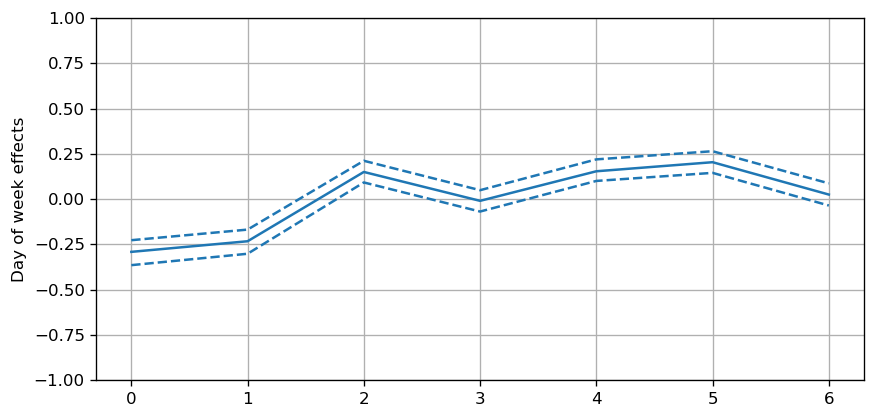

In [5]:
plt.figure(figsize=(8.25, 4.), dpi=120)

model.my_plot(m.beta_dow_cc, range(7))

plt.grid()
plt.ylabel('Day of week effects')
plt.axis(ymin=-1, ymax=1);

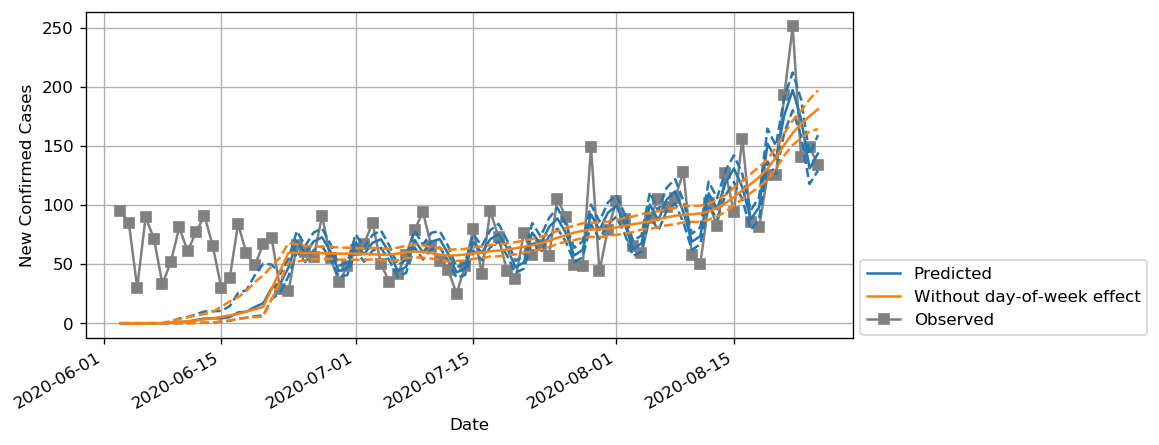

In [6]:
plt.figure(figsize=(8.25, 4.), dpi=120)

model.my_plot(m.mu_cc, m.data.index, 'C0', 'Predicted')
model.my_plot(m.mu_cc_smooth, m.data.index, 'C1', 'Without day-of-week effect')
m.data.n_cc.plot(label='Observed', color='grey', marker='s', zorder=2)

plt.legend(loc=(1.01, .01))
plt.grid()
plt.ylabel('New Confirmed Cases');

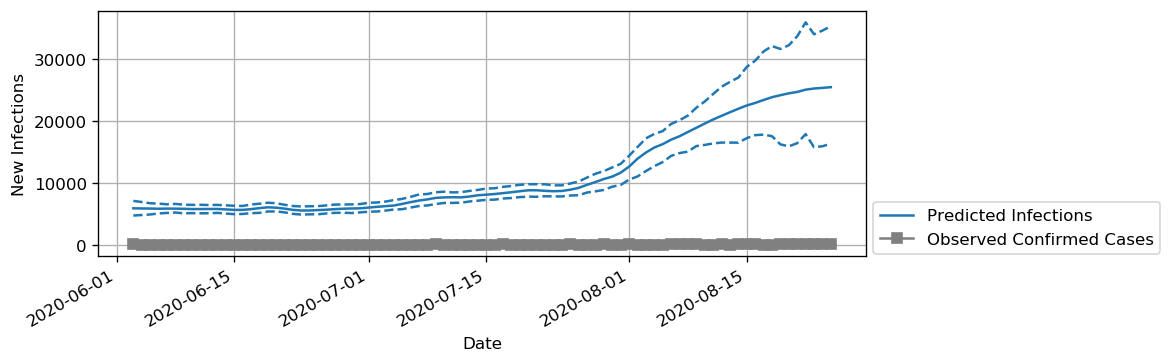

In [7]:
plt.figure(figsize=(8.25, 3.), dpi=120)

model.my_plot(m.X, m.data.index, 'C0', 'Predicted Infections')
m.data.n_cc.plot(label='Observed Confirmed Cases', color='grey', marker='s', zorder=2)

plt.legend(loc=(1.01, .01))
plt.grid()
plt.ylabel('New Infections');

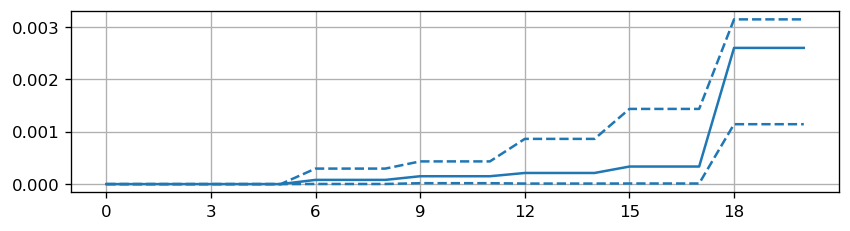

In [8]:
plt.figure(figsize=(8.25, 2.), dpi=120)
model.my_plot(m.cc_kernel, range(21), 'C0', 'Convolution kernel for confirmed cases')
plt.grid()
plt.xticks(range(0,21,3));

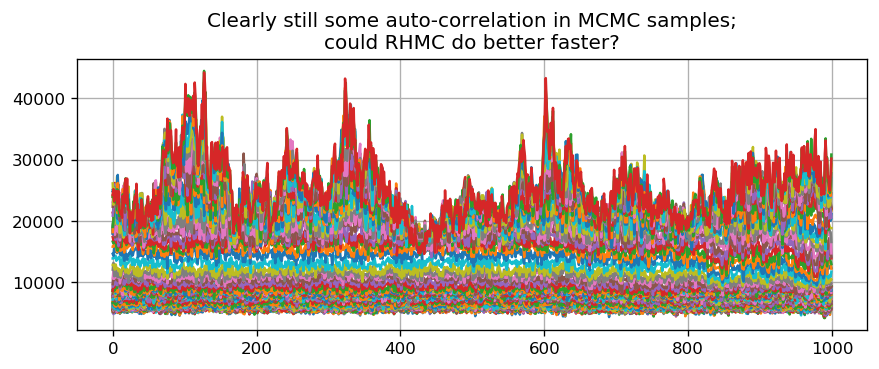

In [9]:
plt.figure(figsize=(8.5, 3), dpi=120)
plt.plot(m.X.trace())
plt.grid()
plt.title('Clearly still some auto-correlation in MCMC samples;\ncould RHMC do better faster?');